# TP1-G2. Filtrado lineal óptimo

**Integrantes:**
- BAUTISTA SCHNEEBERGER
- SANTIAGO EZEQUIEL MANGONE
- SERGIO ANDRES PERALTA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fft
import IPython.display as ipd
from scipy.io import wavfile
import os
from scipy import linalg
import helper

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
font_name = "Times New Roman"
mpl.rcParams['font.family'] = font_name

---
# 1)

In [3]:
fsv2, aaav2_rec = wavfile.read('aaav2.wav')
fsv2, shv2_rec = wavfile.read('shv2.wav')
fs = 16000
aaav2_rec = aaav2_rec[int(2.5*fs):int(3.5*fs)]
aaav2_rec = aaav2_rec.astype(np.float64)/np.max(aaav2_rec)
shv2_rec = shv2_rec[int(5*fs):int(6*fs)]
shv2_rec = shv2_rec.astype(np.float64)/np.max(shv2_rec)

wavfile.write('aaa_1seg.wav', rate=fs, data = aaav2_rec)
wavfile.write('sh_1seg.wav', rate=fs, data = shv2_rec)

display(ipd.Audio(wavfile.read('aaa_1seg.wav')[1], rate=fs))
display(ipd.Audio(wavfile.read('sh_1seg.wav')[1], rate=fs))

---

# 2)
Predictor:

In [4]:
def get_params(x, M):
    y = x
    N = len(x)
    r = signal.correlate(x, x, method = 'fft')
    r = r[N-1:N-1 + M] # Me quedo con los las positivos, es par ... 
    p = signal.correlate(x, y, method = 'fft') 
    p = np.flip(p[N-1 - (M) :N-1]) # Me quedo con los negativos y flipeo asi el primer elemento se corresponde a lag 0
    return r, p
def predictor_lineal_forward(x, M):
    y = x
    r, p = get_params(x, M)
    wo = linalg.solve_toeplitz(r, p)
    Jo_f = np.mean(y**2) - np.dot(p/len(x), wo)
    MSE_normalizado = Jo_f/np.mean(y**2)
    ao = -wo
    return ao, Jo_f, MSE_normalizado
def predict_sequence(x, ao):
    return signal.lfilter(-ao, [1], np.concatenate((np.array([0]), x[:-1]))) 

---
---
---
# Test with Toy Example

$$
y(n) = a_1 y(n-1) + a_2 y(n-2) + w(n)
$$
$$
x(n) = y(n-1)
$$
$$
\hat{y}(n) = w_1 x(n) + w_2 x(n-1)
$$

$$
e(n) = y(n) - \bold{w_o}\cdot \bold{x}(n) 
$$
$$
e(n) = y(n) + \bold{a_o}\cdot \bold{x}(n) 
$$

In [5]:
x = np.random.normal(size=int(1*fs))
a = [1, -0.95, -0.8, 0.9]
y = signal.lfilter([1], a, x)
ao, Jo_f, MSE_normalizado = predictor_lineal_forward(y, 3)

In [6]:
y_hat = predict_sequence(y, ao)

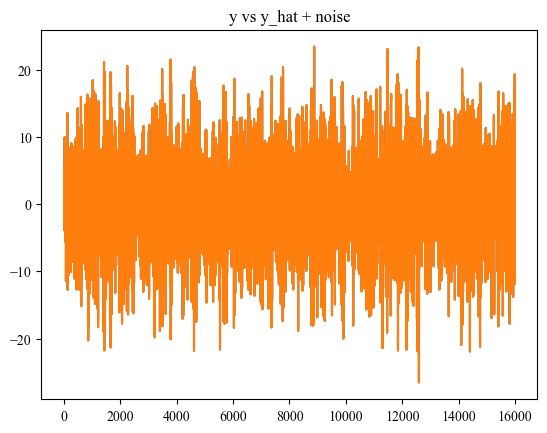

In [7]:
plt.cla()
plt.close()
plt.figure()
plt.plot(y)
plt.plot(y_hat + x)
plt.title('y vs y_hat + noise')
plt.show()

Conclusión: Funciona perfecto

---
---
---
# Ejercicio 2. Continuación. 
# J en función de M

In [8]:
from dataclasses import dataclass, field

@dataclass
class data_prediction:
    M_value: int
    J: int
    ao: np.ndarray = field(default_factory=lambda: np.array([]))

In [9]:
data_dict = {'aaa':[], 'sh':[]}
for M in range(1, 300):
    ao, Jo_f, MSE_normalizado = predictor_lineal_forward(aaav2_rec, M)
    data_dict['aaa'].append(data_prediction(M_value=M, J=Jo_f))
    ao, Jo_f, MSE_normalizado = predictor_lineal_forward(shv2_rec, M)
    data_dict['sh'].append(data_prediction(M_value=M, J=Jo_f))

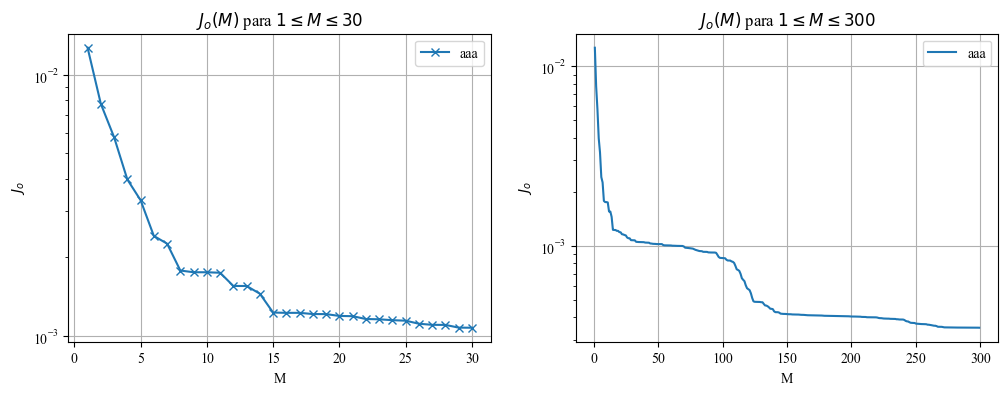

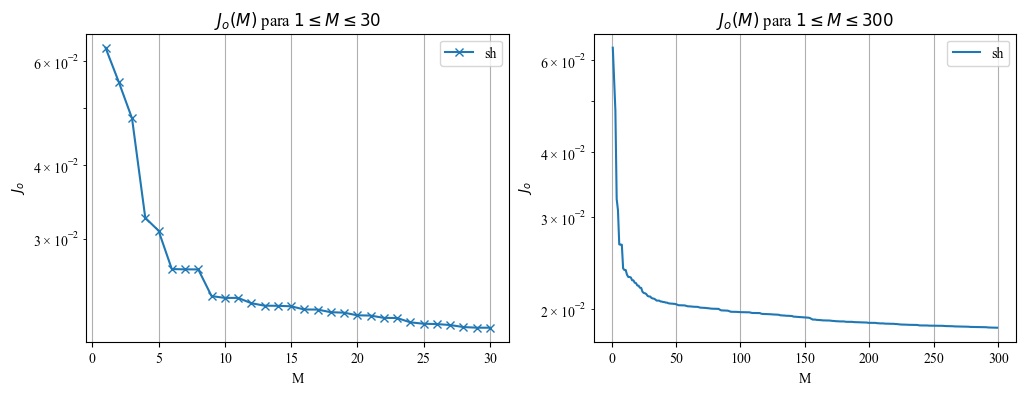

In [10]:
plt.close()
for key in data_dict:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    j = []
    m = []
    for item in data_dict[key]:
        j.append(item.J)
        m.append(item.M_value)
    axes[0].plot(m[:30], j[:30], label = key, marker = 'x')
    axes[0].set_yscale('log')
    axes[0].set_title('$J_o(M)$ para $1\leq M \leq 30$')
    axes[0].grid()
    axes[0].set_xlabel('M')
    axes[0].set_ylabel('$J_o$')
    axes[0].legend()
    axes[1].plot(m, j, label = key)
    axes[1].set_yscale('log')
    axes[1].set_title('$J_o(M)$ para $1\leq M \leq 300$')
    axes[1].grid()
    axes[1].set_xlabel('M')
    axes[1].set_ylabel('$J_o$')
    axes[1].legend()
plt.show()

## Justificación doble codo en /a/  

Si analizamos la señal en el tiempo, podemos notar que se asemeja a una señal periódica de $8 \text{ms}$. Por lo tanto el predictor es de esperar que requiera un orden igual a $M = 8\text{ms}\cdot fs - 1 = 127$ como mínimo para que pueda predecir correctamente. Inspeccionando el gráfico de $J_o\ \text{vs}\ M$ de /a/. Notamos que justamente con $M = 127$ el codo comienza ceder. 

Si observamos la señal temporal, obeservamos que la señal 'periódica' presenta un pico de gran amplitud relativa. Esto nos da pie a entender que un error en el predictor tendrá un valor grande a la hora de predecir ese pico. Por lo tanto si analizamos su espectrograma para $M = 50$ y $M = 150$, deberíamos ver una notable reducción en la energía del error para ese pico.

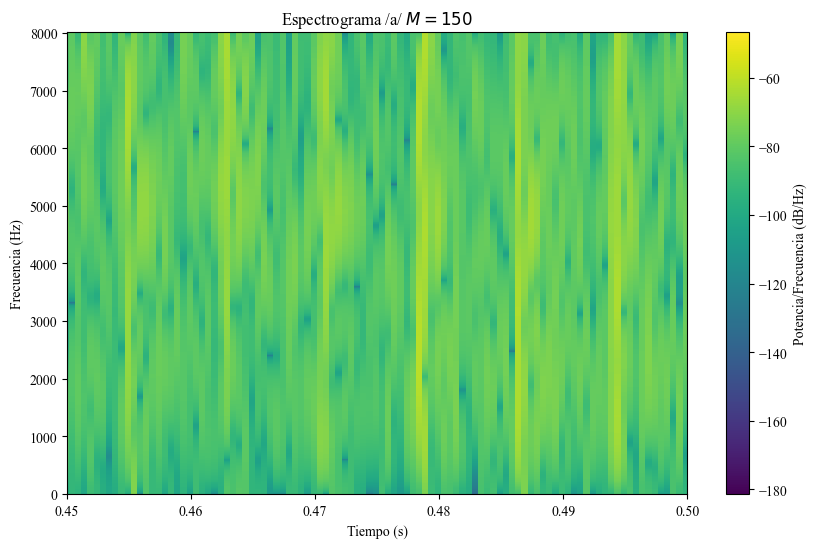

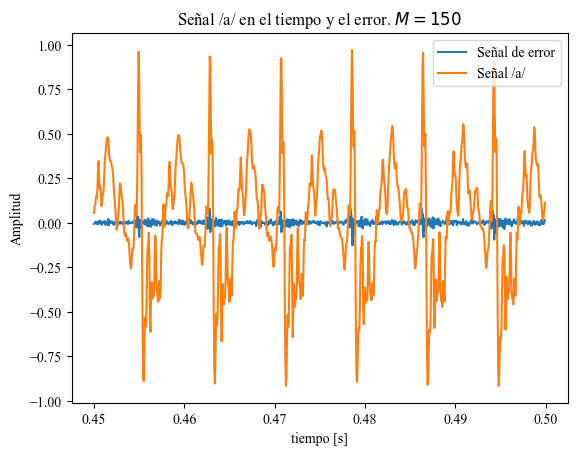

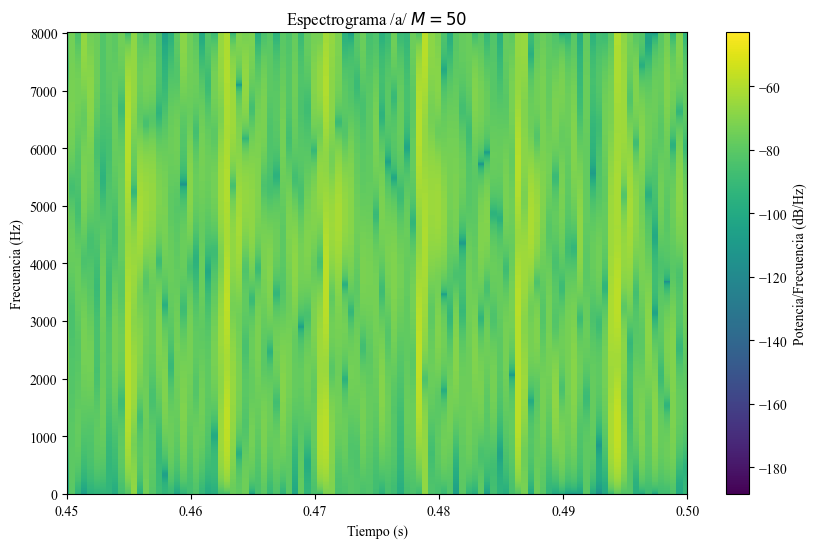

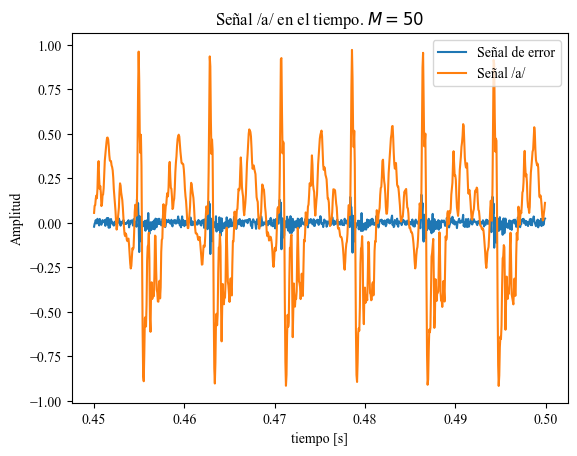

In [11]:
ao,_,_ = predictor_lineal_forward(aaav2_rec, 150)
y_hat = predict_sequence(aaav2_rec, ao)
e_f = aaav2_rec - y_hat

window_size = 0.0008  
overlap = 0.0003 
nperseg = int(fs * window_size) 
noverlap = int(fs * overlap)  
nfft =  1000  

frequencies, times, Sxx = signal.spectrogram(e_f, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
plt.colorbar(label='Potencia/Frecuencia (dB/Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.xlim(0.45, 0.45 + 50e-3)
plt.title('Espectrograma /a/ $M = 150$')
plt.show()

t = np.arange(0, int(0.50*fs) - int(0.45*fs))/fs + 0.45
plt.figure()
plt.plot(t, e_f[int(0.45*fs):int(0.50*fs)], label = 'Señal de error')
plt.plot(t, aaav2_rec[int(0.45*fs):int(0.50*fs)], label = 'Señal /a/')
plt.title('Señal /a/ en el tiempo y el error. $M = 150$')
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

ao,_,_ = predictor_lineal_forward(aaav2_rec, 50)
y_hat = predict_sequence(aaav2_rec, ao)
e_f = aaav2_rec - y_hat
window_size = 0.0008  
overlap = 0.0003  
nperseg = int(fs * window_size)  
noverlap = int(fs * overlap)  
nfft = 1000  

frequencies, times, Sxx = signal.spectrogram(e_f, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
plt.colorbar(label='Potencia/Frecuencia (dB/Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.xlim(0.45, 0.45 + 50e-3)
plt.title('Espectrograma /a/ $M = 50$')
plt.show()

t = np.arange(0, int(0.50*fs) - int(0.45*fs))/fs + 0.45
plt.figure()
plt.plot(t, e_f[int(0.45*fs):int(0.50*fs)], label = 'Señal de error')
plt.plot(t, aaav2_rec[int(0.45*fs):int(0.50*fs)], label = 'Señal /a/')
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Señal /a/ en el tiempo. $M = 50$')
plt.legend()
plt.show()

---
# 3)

In [12]:
M = [1, 2, 4, 8, 16, 32, 64]

data_dict = {'aaa':[], 'sh':[]}
for m in M:
    ao, Jo_f, MSE_normalizado = predictor_lineal_forward(aaav2_rec, m)
    data_dict['aaa'].append(data_prediction(M_value=m, J=Jo_f, ao = ao))
    ao, Jo_f, MSE_normalizado = predictor_lineal_forward(shv2_rec, m)
    data_dict['sh'].append(data_prediction(M_value=m, J=Jo_f, ao = ao))

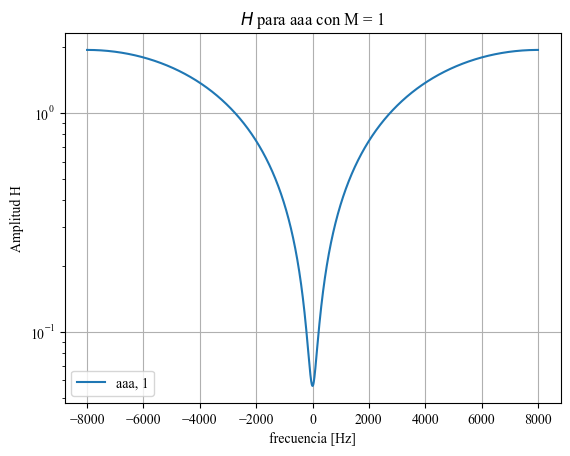

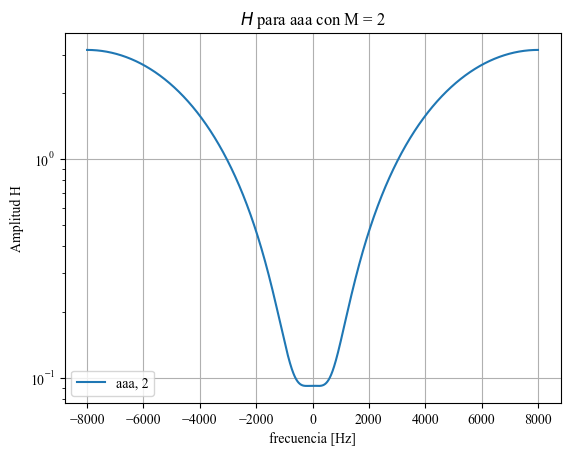

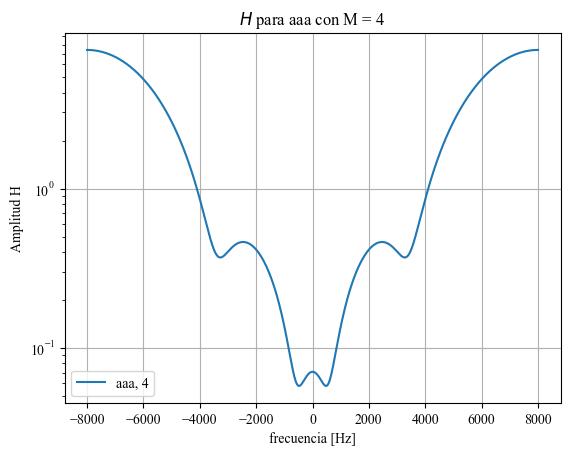

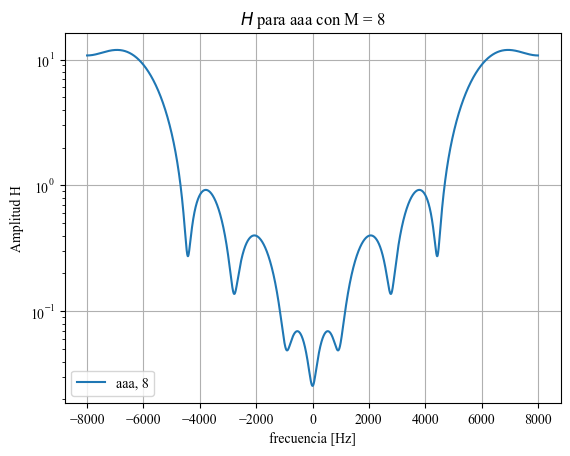

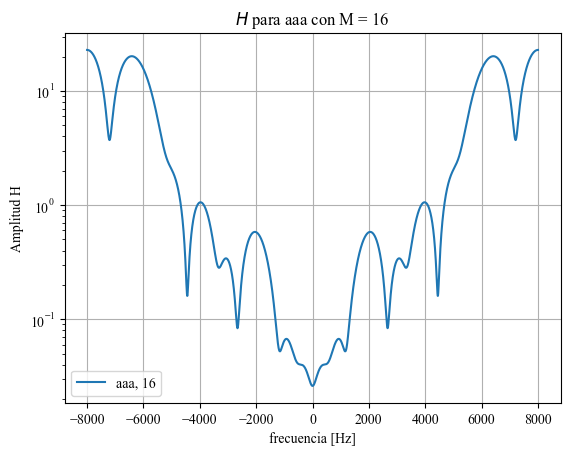

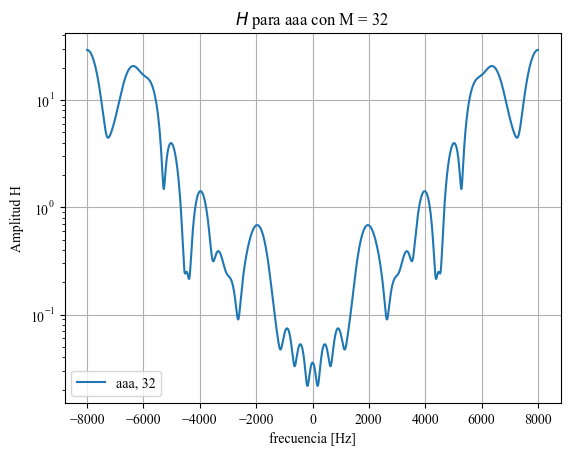

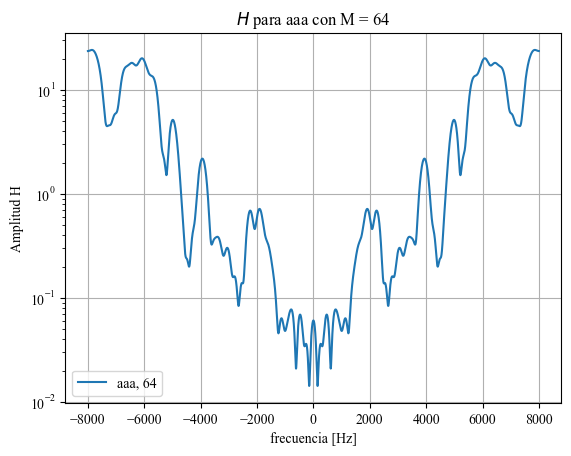

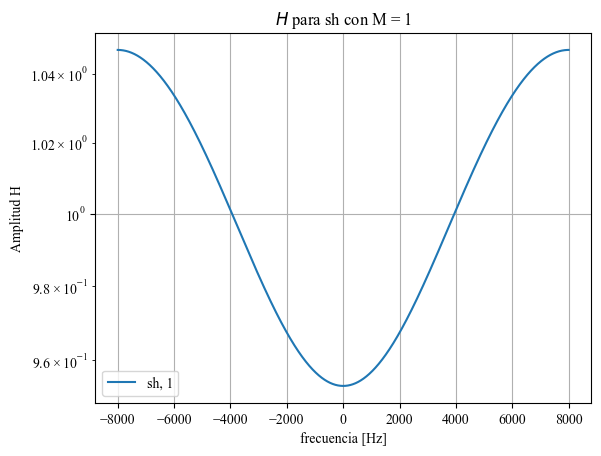

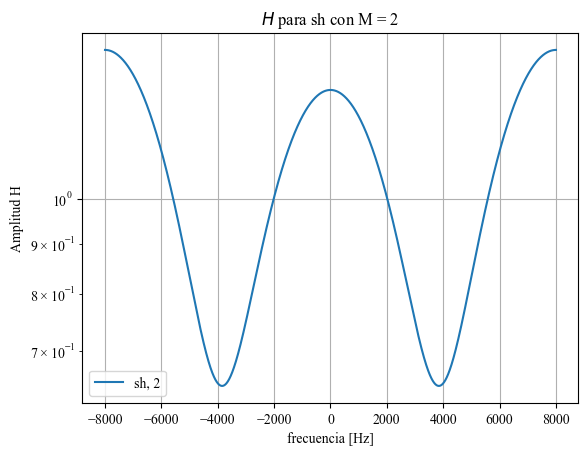

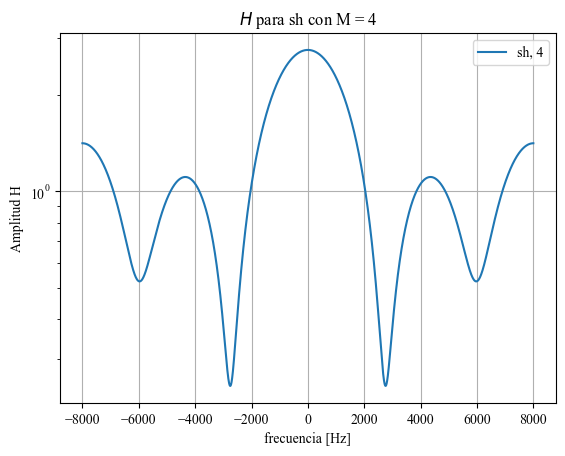

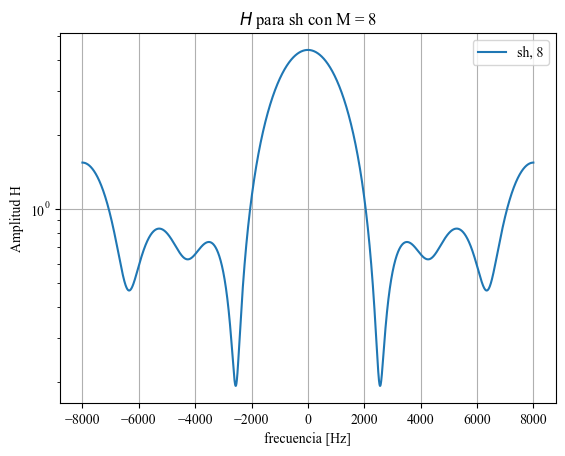

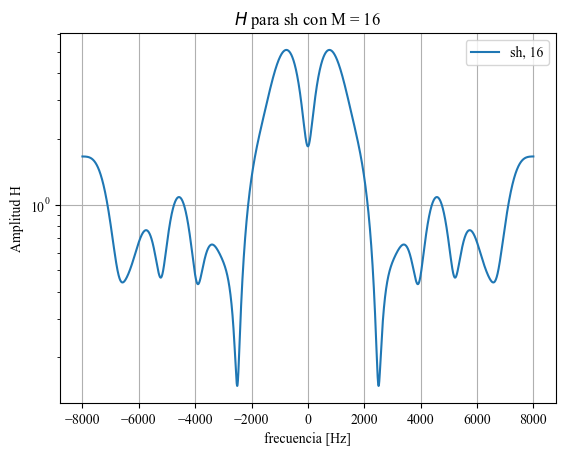

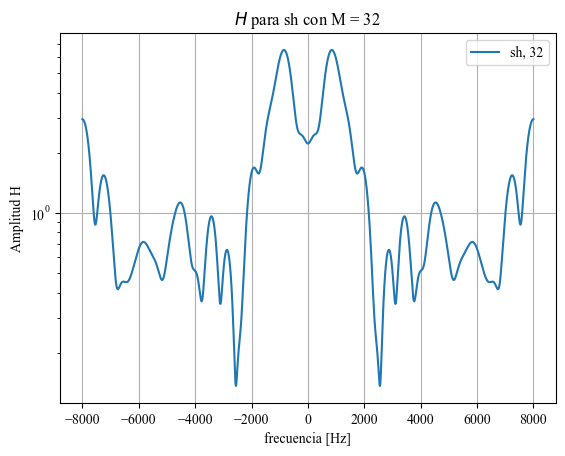

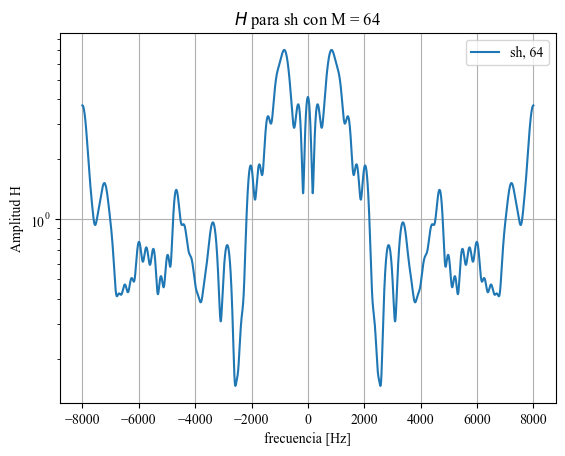

In [13]:
plt.close()
for key in data_dict:
    for item1, m in zip(data_dict[key], M):
        plt.figure()
        a_bar = np.concatenate((np.array([1]), item1.ao))
        H = np.abs(fft.fftshift(fft.fft(a_bar, n= 10000)))
        frecs = fft.fftshift(fft.fftfreq(n = len(H), d = 1/fs))
        plt.plot(frecs, H, label = f'{key}, {m}')
        plt.yscale('log')
        plt.title(f'$H$ para {key} con M = {m}')
        plt.grid()
        plt.xlabel('frecuencia [Hz]')
        plt.ylabel('Amplitud H')
        plt.legend()
        plt.show()

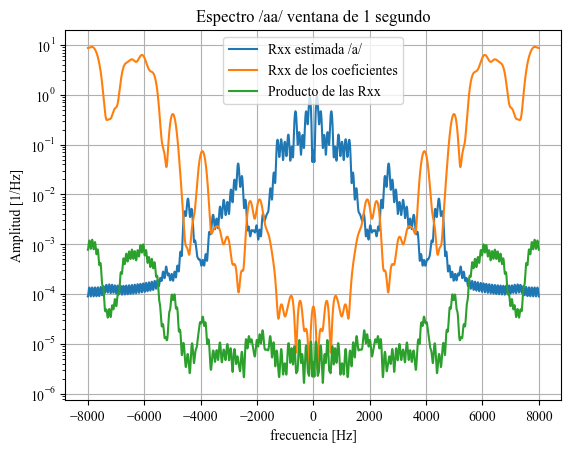

In [14]:
H, _ = helper.periodogram_smoothing(aaav2_rec*signal.get_window(window='blackman', Nx=len(aaav2_rec)), L = int(10e-3*fs), N_FFT=np.max((1000, len(aaav2_rec))))
frecs = fft.fftshift(fft.fftfreq(n = len(H), d = 1/fs))

ao, Jo_f, MSE_normalizado = predictor_lineal_forward(aaav2_rec, 64)
H_coef = np.abs(fft.fftshift(fft.fft( x = np.concatenate((np.array([1]), ao)), n = len(H) ) ) )**2 / (len(ao)+1)

plt.plot(frecs, H, label = 'Rxx estimada /a/')
plt.plot(frecs, H_coef, label = 'Rxx de los coeficientes')
plt.plot(frecs, H_coef * H, label = 'Producto de las Rxx')
plt.yscale('log')
plt.title('Espectro /aa/ ventana de 1 segundo')
plt.grid()
plt.xlabel('frecuencia [Hz]')
plt.ylabel('Amplitud [1/Hz]')
plt.legend()
plt.show()

Con estos dos últimos gráficos se pudo comprobar que el filtro del error de predicción es el inverso (o tiende) al espectro de la señal de entrada. Justamente para que el error sea la señal whiten. La señal producto de las H, parece bastante whiten, salvo en las esquinas pero ahí se debe al bias a de la estimación de la Rxx de la voz, que se noto que en las esquinas tenia bias.

---
# 4)

Para $M = 100$ podemos decir que 'termina el codo' dado que es cuando $J_o$ comienza a descender abruptamente hasta llegar al segundo codo.

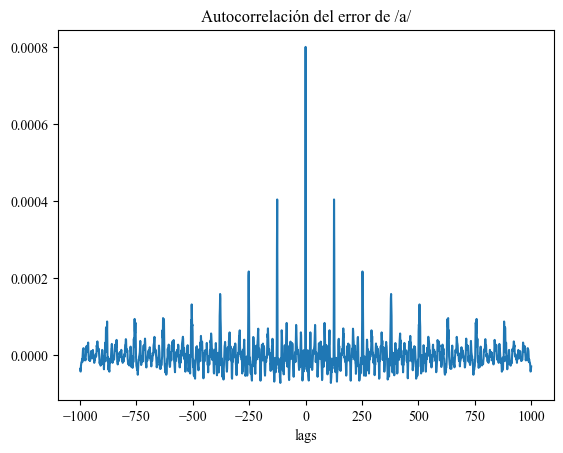

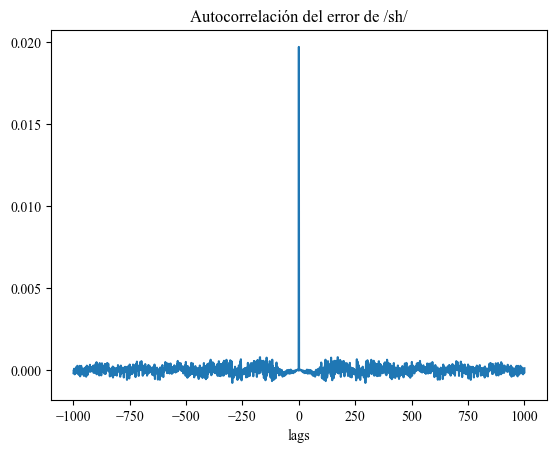

In [15]:
M = 100
ao, _, _ = predictor_lineal_forward(aaav2_rec, M)
y_hat = predict_sequence(aaav2_rec, ao)

plt.close()
plt.figure()
plt.title('Autocorrelación del error de /a/')
plt.plot(signal.correlation_lags(len(y_hat), len(y_hat))[15000:17000], signal.correlate(aaav2_rec - y_hat, aaav2_rec - y_hat)[15000:17000]/len(aaav2_rec - y_hat))
plt.xlabel('lags')
plt.show()

M = 100
ao, _, _ = predictor_lineal_forward(shv2_rec, M)
y_hat = predict_sequence(shv2_rec, ao)

plt.close()
plt.figure()
plt.title('Autocorrelación del error de /sh/')
plt.xlabel('lags')
plt.plot(signal.correlation_lags(len(y_hat), len(y_hat))[15000:17000], signal.correlate(shv2_rec - y_hat, shv2_rec - y_hat)[15000:17000]/len(shv2_rec - y_hat))
plt.show()

Notamos que la señal de error de /sh/ es prácticamente blanca, mientras que la señal de error para /a/ no lo es tanto, la separación entre los palitos de amplitud decreciente se corresponden con el periodo de la señal. Se propone un modelo simple gaussiano blanco para aplicarle el filtro inverso obtenido y poder escuchar la entonación /a/ y /sh/. 

In [16]:
M = 120
ao, _, _ = predictor_lineal_forward(aaav2_rec, M)

w = 1*np.random.normal(size = int(fs*2))
y = signal.lfilter(a=np.concatenate((np.array([1]), ao)), b=[1], x=w)

wavfile.write(data=y, rate = fs, filename='aa_reversed.wav')
display(ipd.Audio(wavfile.read('aa_reversed.wav')[1], rate=fs))

M = 120
ao, _, _ = predictor_lineal_forward(shv2_rec, M)

w = 1*np.random.normal(size = int(fs*2))
y = signal.lfilter(a=np.concatenate((np.array([1]), ao)), b=[1], x=w)

wavfile.write(data=y, rate = fs, filename='sh_reversed.wav')
display(ipd.Audio(wavfile.read('sh_reversed.wav')[1], rate=fs))

/sh/ se escucha igual a la grabación original. /a/ no tanto, parece tener más reberberación. En primer lugar, dado que el el error de predicción de /sh/ anteriormente mostrado era bastante blanco, ahora que probamos metiendo ruido blanco gaussiano tiene sentido que se escuche similar. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


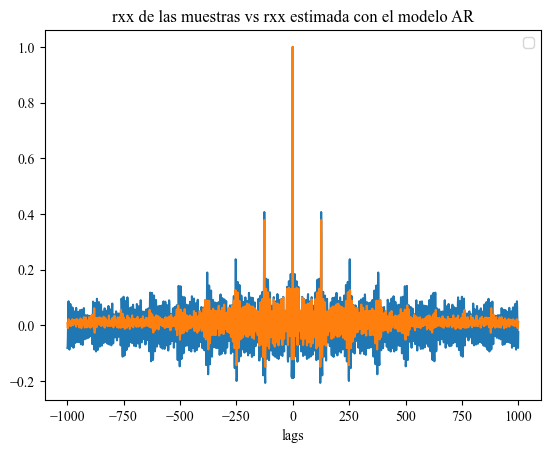

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

M = 120
ao, _, _ = predictor_lineal_forward(aaav2_rec, M)
y_hat = predict_sequence(aaav2_rec, ao)
e_f = aaav2_rec - y_hat

p = 150
model = AutoReg(e_f, p)
results = model.fit()

s = signal.lfilter(b= [1], a = np.concatenate((np.array([1]), -results.params[1:])), x=np.random.normal(size = int(1*fs)))

plt.close()
plt.figure()
lags = signal.correlation_lags(len(s), len(s))
plt.plot(lags[15000:17000], signal.correlate(s, s)[15000:17000]/(len(s)*np.mean(s**2)))
plt.plot(lags[15000:17000], signal.correlate(e_f, e_f)[15000:17000]/(len(e_f)*np.mean(e_f**2)))
plt.legend()
plt.title('rxx de las muestras vs rxx estimada con el modelo AR')
plt.xlabel('lags')
plt.show()


Probemos ahora coloreando el ruido blanco con este modelo obtenido para la entoncación /a/

In [18]:
M = 120
ao, _, _ = predictor_lineal_forward(aaav2_rec, M)

w = 1*np.random.normal(size = int(fs*2))
y_colored = signal.lfilter(b= [1], a = np.concatenate((np.array([1]), -results.params[1:])), x=w)
y = signal.lfilter(a=np.concatenate((np.array([1]), ao)), b=[1], x=y_colored)
wavfile.write(data=y, rate = fs, filename='aa_reversed_AR.wav')
display(ipd.Audio(wavfile.read('aa_reversed_AR.wav')[1], rate=fs))

Ahora se escucha mucho mejor pero sigue sonando mal.

---
# 5)

In [19]:
fs, frase = wavfile.read("voz.wav")

window_time = 50e-3
L = int(window_time*fs)
overlap = int(L/2)
window = signal.get_window('hann', L)
splitted_frase = np.array([frase[i*overlap : i*overlap + L]*window for i in range(0, len(frase)//overlap-1)])

M = 120
ftrain = 160
slen = len(splitted_frase)
a_bar = np.zeros((slen, M+1))

for i in range(slen):
    ao, _, _ = predictor_lineal_forward(splitted_frase[i], M)
    a_bar[i] = np.concatenate((np.array([1]), ao))

impulses = signal.unit_impulse(len(frase), [np.arange(0, len(frase) + 1, fs//ftrain)])
splitted_impulse = np.array([impulses[i*overlap : i*overlap + L] for i in range(0, len(impulses)//overlap-1)])

results = np.zeros(overlap*(slen+1))

for i, coeffs in enumerate(a_bar):
    results[i*overlap : i*overlap + L] += window * signal.lfilter([1], coeffs, splitted_impulse[i])

wavfile.write(data=results, rate=fs, filename='frase_reversed.wav')
display(ipd.Audio(wavfile.read('voz.wav')[1], rate=fs))
display(ipd.Audio(wavfile.read('frase_reversed.wav')[1], rate=fs))

En cada ventana de $50\text{ms}$ consideramos que la nota de la voz es constante, obtenemos los coeficientes del filtro predictor de error para ese intervalo. Luego con el tren de deltas, que en espectro también será un tren de deltas, filtrandolo con el sistema inverso del error, 'shaipiamos' este espectro de deltas con el espectro de la nota de voz estimado en los $50\text{ms}$. 

Para $M=12$ resulta inentendible la grabación con el vocoder, pero para $M=120$ es más entendible